# Recommender Systems

I will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies.

You will need to know the column names of the columns to read the data efficiently:

`columns_name = ['user_id', 'item_id', 'rating', 'timestamp']`

In this project, I will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately, it just tells you what movies/items are most similar to your movie choice.

## Set up

### Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading data and data manipulation

In [6]:
# Read the main data
columns_name = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep = '\t', names = columns_name)
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [7]:
# Get the movei titles
movie_title = pd.read_csv('Movie_Id_Titles')
movie_title

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [8]:
# Link the movie title to item_id
df = pd.merge(df, movie_title, on = 'item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,0,172,5,881250949,"Empire Strikes Back, The (1980)"
2,0,133,1,881250949,Gone with the Wind (1939)
3,196,242,3,881250949,Kolya (1996)
4,186,302,3,891717742,L.A. Confidential (1997)


#### Create a rating dataframe
To explore the data, I need to group it somehow to have a more intuitive understanding of how movies are rated and why. I want to groupby our movies by rating and determine the average rating for those movies. However, something to have in consideration is that this won't be weighted by the total number of reviews, so movies with only one person rating it 5 starts will be at the top of the list. To account for that, we will also add the total number of reviews to the rating dataframe.

In [10]:
# Create a rating dataframe
df.groupby('title')['rating'].mean().sort_values(ascending = False).head(10)

title
They Made Me a Criminal (1939)                       5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Saint of Fort Washington, The (1993)                 5.0
Someone Else's America (1995)                        5.0
Star Kid (1997)                                      5.0
Great Day in Harlem, A (1994)                        5.0
Aiqing wansui (1994)                                 5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Name: rating, dtype: float64

In [11]:
df.groupby('title')['rating'].count().sort_values(ascending = False).head(10)

title
Star Wars (1977)                 584
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

In [12]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [14]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [15]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


## Exploratory data analysis

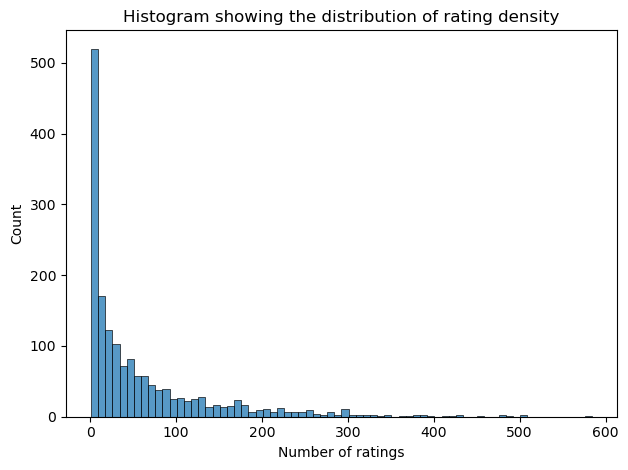

In [18]:
sns.histplot(ratings['num of ratings'], bins = 70)
plt.xlabel('Number of ratings')
plt.title('Histogram showing the distribution of rating density')
plt.tight_layout()

This is a typical Poisson distributed variables, where most movies only have one rating and very few movies (only the most popular, will have a high number of ratings.

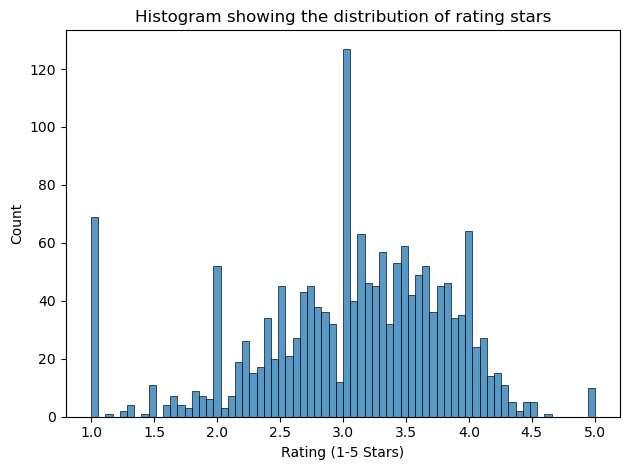

In [20]:
sns.histplot(ratings['rating'], bins = 70)
plt.xlabel('Rating (1-5 Stars)')
plt.title('Histogram showing the distribution of rating stars')
plt.tight_layout()

The rating follows a clearer normal distribution with an average close to 3.25 stars. However, note the peaks at 1 (very bad movies) and 5 (very good movies). This is an expected behaviour where people will rate extremes based on emmotional attachtment to movies.

Let's now look at the 2 variables together and their relationship.

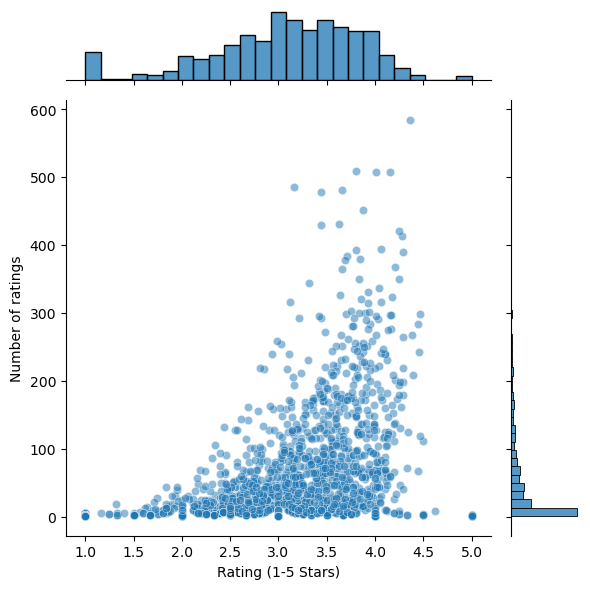

In [22]:
sns.jointplot(x = 'rating', y= 'num of ratings', data = ratings, alpha = 0.5)
plt.xlabel('Rating (1-5 Stars)')
plt.ylabel('Number of ratings')
plt.tight_layout()

As you get more rating, you tend to have higher rating stars for that movie. This makes sense because as better a movie is more people are going to watch it and, thus, more people rating it. That is why very bad movies have very few ratings and movies between 3.5-4 stars have a lot of ratings.

Now that we know what the data looks like and features relate to each other, I have a better understanding to be able to apply a recommendation system based on item similarity.

## Recommendation System

### More data manipulation
I need to create a matrix that has the user ID and movie title as axes. Cells will contain the rating information that the user have to the movie.

In [36]:
moviemat = df.pivot_table(values='rating',
                          index='user_id',
                          columns='title',
                         )
moviemat

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To understand this matrix better, let's check some of the most rated movies.

In [24]:
ratings.sort_values('num of ratings', ascending = False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


### Correlation between movies

I will choose 2 movies: "Star Wars" and "Liar Liar".

In [25]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

In [26]:
starwars_user_ratings

user_id
0      5.0
1      5.0
2      5.0
3      NaN
4      5.0
      ... 
939    NaN
940    4.0
941    NaN
942    5.0
943    4.0
Name: Star Wars (1977), Length: 944, dtype: float64

I get a series of rating for that movie, and we can explore the correlation between the rating given to these movies by the users. Basically, trying to understand if a user who liked "Star Wars" also likes "Liar Liar". We will explore this with the power of `corrwith()`, which will allow me to correlate an external column (here 'Star Wars' and 'Lier Lier') to all the other columns in a dataset (here the matrix, where each column is a movie). This will result in an output with the movies and their correlation with the Star Wars rating. This answers the question of what movies are preferred among those people who like Star Wars

In [32]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_starwars.head(10)

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)                      0.872872
1-900 (1994)                                  -0.645497
101 Dalmatians (1996)                          0.211132
12 Angry Men (1957)                            0.184289
187 (1997)                                     0.027398
2 Days in the Valley (1996)                    0.066654
20,000 Leagues Under the Sea (1954)            0.289768
2001: A Space Odyssey (1968)                   0.230884
3 Ninjas: High Noon At Mega Mountain (1998)         NaN
39 Steps, The (1935)                           0.106453
dtype: float64

This gives me all the movies and their correlation with Star Wars user rating

In [31]:
similar_to_starwars.sort_values(ascending = False).head(10)

title
Hollow Reed (1996)                                                                   1.0
Commandments (1997)                                                                  1.0
Cosi (1996)                                                                          1.0
No Escape (1994)                                                                     1.0
Stripes (1981)                                                                       1.0
Star Wars (1977)                                                                     1.0
Man of the Year (1995)                                                               1.0
Beans of Egypt, Maine, The (1994)                                                    1.0
Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)    1.0
Outlaw, The (1943)                                                                   1.0
dtype: float64

In [35]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)
similar_to_liarliar.head(10)

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


title
'Til There Was You (1997)                      0.118913
1-900 (1994)                                        NaN
101 Dalmatians (1996)                          0.469765
12 Angry Men (1957)                            0.066272
187 (1997)                                     0.175145
2 Days in the Valley (1996)                    0.040739
20,000 Leagues Under the Sea (1954)           -0.027932
2001: A Space Odyssey (1968)                  -0.057864
3 Ninjas: High Noon At Mega Mountain (1998)         NaN
39 Steps, The (1935)                           0.400918
dtype: float64

Let's clean the datasets to remove NaN and transform it to a pandas dataframe

In [55]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns = ['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head(10)

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
"39 Steps, The (1935)",0.106453


In [48]:
corr_starwars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1410 entries, 'Til There Was You (1997) to unknown
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Correlation  1410 non-null   float64
dtypes: float64(1)
memory usage: 22.0+ KB


### Addressing bias
If I sort the data by correlation, I should get the most related movies for the user's likeliness. However, I might get many movies with perfect correlation. This does not make sense, and it arises from individual users who have watched both movies and given the same score. I want the recommendation to be more robust, so we have to deal with this phenomenon.

In [56]:
corr_starwars.sort_values('Correlation', ascending=False).head(20)

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


I will fix this by applying a threshold that filters out movies with a low number of reviews (below the threshold). This should partly address this issue for niche cases.

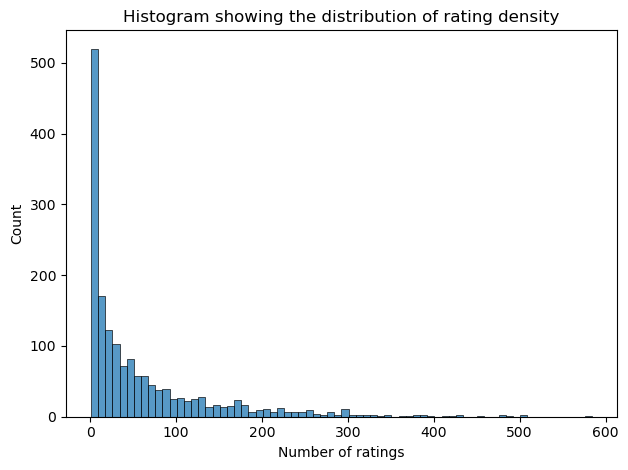

In [57]:
sns.histplot(ratings['num of ratings'], bins = 70)
plt.xlabel('Number of ratings')
plt.title('Histogram showing the distribution of rating density')
plt.tight_layout()

We show a clear decline in ratings after the 100 mark. So, perhaps this would be a good threshold to make the model more robust.

### Recommendation system for "Star Wars"

To reduce bias, I will need to first link our correlation data to the number of ratings, so that we can filter out movies with a low number of ratings

In [58]:
corr_starwars = corr_starwars.join(ratings['num of ratings']) # here we use join instead of merge
# because our joining link is the index of the dataset, not a column.
# In both ratings and corr_starwars, the title of the movie is in the index. Thus, the use of join.
corr_starwars

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41
...,...,...
Young Guns (1988),0.186377,101
Young Guns II (1990),0.228615,44
"Young Poisoner's Handbook, The (1995)",-0.007374,41


In [59]:
corr_starwars[corr_starwars['num of ratings'] > 100]

,Correlation,num of ratings
title,,
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
2001: A Space Odyssey (1968),0.230884,259
Absolute Power (1997),0.085440,127
"Abyss, The (1989)",0.203709,151
...,...,...
Willy Wonka and the Chocolate Factory (1971),0.221902,326
"Wizard of Oz, The (1939)",0.266335,246
"Wrong Trousers, The (1993)",0.216204,118


We have filtered out 1076 movies (1410 - 334)

In [60]:
corr_starwars[corr_starwars['num of ratings'] > 100].sort_values('Correlation', ascending=False).head(10)

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


Now, this makes more sense. After the self-correlation, the most correlated movie is "The Empire Strikes Back", followed by "Return of the Jedi", which makes sense as you are likely going to enjoy these movies if you rated "Star Wars" very high.

We see a big drop in correlation when we move away from the Star Wars franchise due to the lower similarity between the movies, and therefore less probability of matching.

### Recommendation system for "Liar Liar"

In [64]:
corr_liarliar = pd.DataFrame(similar_to_liarliar, columns = ['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar.sort_values('Correlation', ascending=False).head(20)

,Correlation
title,
"Bonheur, Le (1965)",1.0
For Ever Mozart (1996),1.0
Crossfire (1947),1.0
Johnny 100 Pesos (1993),1.0
Moonlight and Valentino (1995),1.0
Mina Tannenbaum (1994),1.0
"Stranger, The (1994)",1.0
"Wooden Man's Bride, The (Wu Kui) (1994)",1.0
Legal Deceit (1997),1.0


In [65]:
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar.head(10)

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.118913,9
101 Dalmatians (1996),0.469765,109
12 Angry Men (1957),0.066272,125
187 (1997),0.175145,41
2 Days in the Valley (1996),0.040739,93
"20,000 Leagues Under the Sea (1954)",-0.027932,72
2001: A Space Odyssey (1968),-0.057864,259
"39 Steps, The (1935)",0.400918,59
8 1/2 (1963),0.178064,38


In [67]:
corr_liarliar[corr_liarliar['num of ratings'] > 100].sort_values('Correlation', 
                                                                 ascending=False).head(10)

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164
101 Dalmatians (1996),0.469765,109
Michael (1996),0.442022,119
Waterworld (1995),0.438405,102


These systems can be strengthened by playing with the number of recommendations to reanalyse the top recommended movies. For example, for Liar Liar, Batman Forever makes less sense as an intuitive recommendation, while The Mask seems to greatly align with the Liar Liar theme.

### Recommendations

In [75]:
print('If you liked "Star Wars" here are the next top 5 recommended movies for you!')
print('-----------------------------------------------------------------------------')
top_5_starwars = corr_starwars[corr_starwars['num of ratings'] > 100].sort_values('Correlation', 
                                                                                  ascending=False).head(6)
for i, movie in enumerate(top_5_starwars[1:].index, start = 1):
    print(f'{i}. {movie}')

If you liked "Star Wars" here are the next top 5 recommended movies for you!
-----------------------------------------------------------------------------
1. Empire Strikes Back, The (1980)
2. Return of the Jedi (1983)
3. Raiders of the Lost Ark (1981)
4. Austin Powers: International Man of Mystery (1997)
5. Sting, The (1973)


In [76]:
print('If you liked "Liar Liar" here are the next top 5 recommended movies for you!')
print('-----------------------------------------------------------------------------')
top_5_liarliar = corr_liarliar[corr_liarliar['num of ratings'] > 100].sort_values('Correlation', 
                                                                 ascending=False).head(6)
for i, movie in enumerate(top_5_liarliar[1:].index, start = 1):
    print(f'{i}. {movie}')

If you liked "Liar Liar" here are the next top 5 recommended movies for you!
-----------------------------------------------------------------------------
1. Batman Forever (1995)
2. Mask, The (1994)
3. Down Periscope (1996)
4. Con Air (1997)
5. Pretty Woman (1990)


# --- End of Project! ---